In [5]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [6]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [32]:
def normalize_position_and_rotation(samples: list[torch.tensor]) -> torch.tensor:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in samples])
    rotations = torch.stack([s[3:] for s in samples])

    # normalize position to the first sample
    positions = positions - positions[0]
    
    # normalize rotation to the first sample (remember quaternion rotations)
    new_rot = []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot])

    return torch.concatenate((positions, new_rot), axis=1)

In [33]:
def reset_position_and_rotation_to_first_node(nodes, edge_index, y):
  y = normalize_position_and_rotation(y)
  return nodes, edge_index, y

In [34]:
dataset = MultipleSequenceGraphDataset(basedir, train_sequences, transform=reset_position_and_rotation_to_first_node)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss()

In [35]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

loss_history = []
for epoch in range(10):
    model.train()
    loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})

    print(f"Epoch {epoch} loss: {sum(loss_history) / len(loss_history)}")

# time
torch.save(model.state_dict(), f"models/model_{time.time()}.pth")

Epoch 0:   0%|          | 0/319 [00:00<?, ?it/s]

Original y: [tensor([-1.9239e+02, -1.4717e+00,  1.7007e+02,  1.1898e-02,  7.2902e-01,
         1.5820e-02, -6.8420e-01]), tensor([-1.9331e+02, -1.4586e+00,  1.7000e+02,  1.1903e-02,  7.2943e-01,
         1.5980e-02, -6.8376e-01]), tensor([-1.9423e+02, -1.4447e+00,  1.6993e+02,  9.5575e-03,  7.3031e-01,
         1.6107e-02, -6.8286e-01]), tensor([-1.9515e+02, -1.4297e+00,  1.6986e+02,  8.7442e-03,  7.3150e-01,
         1.6368e-02, -6.8159e-01]), tensor([-1.9697e+02, -1.4041e+00,  1.6970e+02,  8.9285e-03,  7.3407e-01,
         1.9077e-02, -6.7874e-01])]
Normalized y: tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  1.0000e+00],
        [-9.2340e-01,  1.3110e-02, -6.6299e-02,  1.1902e-04,  6.0410e-04,
          1.1776e-04,  1.0000e+00],
        [-1.8429e+00,  2.7013e-02, -1.3950e-01, -1.3970e-03,  1.8222e-03,
          1.9391e-03,  1.0000e+00],
        [-2.7586e+00,  4.1926e-02, -2.1251e-01, -1.7669e-03,  3.5391e-03,
          2.7448e-03,  9

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

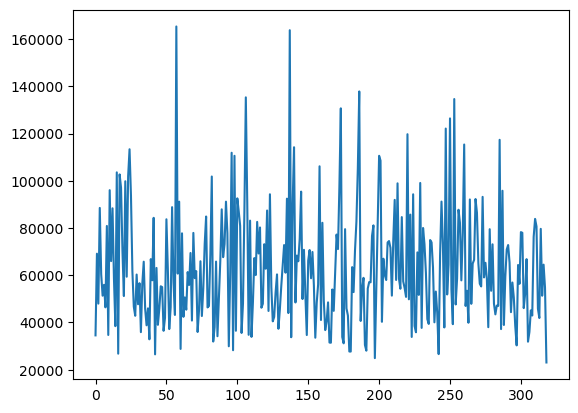

In [ ]:
# plot loss
plt.plot(loss_history)
plt.show()

In [ ]:
test_dataset = KittiGraphDataset(basedir, "09")
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]

    rot = R.from_quat(rot).as_euler("xyz", degrees=True)
    return pos, rot

In [ ]:
predicted_poses = []
true_poses = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch)
        predicted_poses.append(output.cpu().numpy())
        true_poses.append(batch.y.cpu().numpy())

100%|██████████| 1586/1586 [00:03<00:00, 469.73it/s]


In [ ]:
kitti_dataset = KittiSequenceDataset(basedir, "09", return_rich_sample=True)
trajectory_image = np.zeros((2000, 2000, 3), dtype=np.uint8)

for index, sample in enumerate(tqdm(kitti_dataset)):
    image = np.array(sample["image"])
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    try:
        true_pose = true_poses[index][0]
        predicted_pose = predicted_poses[index][0]
    except IndexError:
        break

    true_position, true_rotation = tensor_to_position_and_rotation(true_pose)
    predicted_position, predicted_rotation = tensor_to_position_and_rotation(predicted_pose)

    cv2.circle(trajectory_image, int(true_position[0] + 1000), int(true_position[2] + 1000), 1, (0, 0, 255), 1)
    cv2.circle(trajectory_image, int(predicted_position[0] + 1000), int(predicted_position[2] + 1000), 1, (0, 255, 0), 1)

    # cv2.imshow("image", image)
    # cv2.imshow("trajectory", trajectory_image)
    # cv2.waitKey(1)

cv2.destroyAllWindows()

  0%|          | 0/1591 [00:00<?, ?it/s]